In [ ]:
# !pip install -U numpyro --quiet;

     |████████████████████████████████| 292 kB 4.9 MB/s 


In [ ]:
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from functools import partial

from jax import jit, vmap
import jax.numpy as jnp
from jax import random
# import jax

import matplotlib.pyplot as plt

In [ ]:
# TODO: WHY multiple cores so slow here ... works contaminated normal... 

# jax.config.update('jax_platform_name', 'cpu')
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)
# jax.local_device_count()

In [ ]:
key = random.PRNGKey(1)

In [ ]:
# t1, t2, t3, t4, t5 = 0.7, -2.9, -1.0, -0.9, 0.6
# batch_size = 1

# m_theta = jnp.array([t1, t2])
# s1 = t3 ** 2
# s2 = t4 ** 2
# rho = jnp.tanh(t5)
# cov_mat = jnp.array([[s1 ** 2, rho * s1 * s2], [rho * s1 * s2, s2 ** 2]])
# print('cov_mat: ', cov_mat)
# y = dist.MultivariateNormal(m_theta, cov_mat).sample(key=key, sample_shape=((batch_size, 4)))
# y.reshape(batch_size, -1)

In [ ]:
def misspecification_transform(x, misspec_level=1.0, key=None):
    misspec_x = x + 100 * dist.Normal(0, 1).sample(key, sample_shape=(10,)) * misspec_level * jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0])
    return misspec_x

In [ ]:
# @partial(jit, static_argnums=(5,6))
def true_dgp(t1, t2, t3, t4, t5, batch_size=1, key=None):
  m_theta = jnp.array([t1, t2])
  s1 = t3 ** 2
  s2 = t4 ** 2
  rho = jnp.tanh(t5)
  cov_mat = jnp.array([[s1 ** 2, rho * s1 * s2], [rho * s1 * s2, s2 ** 2]])
  y = dist.MultivariateNormal(m_theta, cov_mat).sample(key=key, sample_shape=((batch_size, 5)))  # TODO: CHANGED TO 5

  return y.reshape(batch_size, -1)

In [ ]:
# @partial(jit, static_argnums=(5,6,7))
def assumed_dgp(t1, t2, t3, t4, t5, std_err=1.0, batch_size=1, key=None):
  x = true_dgp(t1, t2, t3, t4, t5, batch_size, key)
  # gauss_noise1 = dist.Normal(0, 1).sample(key, sample_shape=(batch_size, 6))
  # gauss_noise2 = dist.Normal(0, 2).sample(key, sample_shape=(batch_size, 2))
  # gauss_noise = jnp.hstack((gauss_noise1[:, :4], gauss_noise2, gauss_noise1[:, 4:]))
  # misspec_x = x + (100 * std_err * gauss_noise)
  # misspec_x = x * jnp.array([1.0, 1.0, 1.0, 1.0, 4.0, 6.0, 1.0, 1.0])
  return x

In [ ]:
# batch_size = 10
# gauss_noise1 = dist.Normal(0, 1).sample(key, sample_shape=(batch_size, 6))
# gauss_noise2 = dist.Normal(0, 2).sample(key, sample_shape=(batch_size, 2))
# gauss_noise = jnp.hstack((gauss_noise1[:, :4], gauss_noise2, gauss_noise1[:, 4:]))

In [ ]:
def summ_stats(x):
  return x

In [ ]:
# @partial(jit, static_argnums=(1,2))
def simulation_wrapper(params, batch_size=1, key=None):
  x_sim = assumed_dgp(*params, batch_size=batch_size, key=key)
  sim_sum = summ_stats(x_sim)
  return sim_sum.reshape((batch_size, -1))

In [ ]:
key, subkey = random.split(key)
# thetas = dist.Uniform(-3, 3).sample(key=subkey, sample_shape=(5,))
true_params = jnp.array([0.7, -2.9, -1.0, -0.9, 0.6])

In [ ]:
true_params

DeviceArray([ 0.7, -2.9, -1. , -0.9,  0.6], dtype=float32)

In [ ]:
key, subkey1, subkey2 = random.split(key, 3)
x_obs = misspecification_transform(jnp.squeeze(summ_stats(true_dgp(*true_params, key=subkey1))), key=subkey2)
x_obs = jnp.squeeze(x_obs)

In [ ]:
x_obs

DeviceArray([   0.51417744,   -2.1834092 ,    2.279926  ,   -1.3189619 ,
                2.8727434 ,   -3.3031068 ,    1.5085756 ,   -3.9590554 ,
             -172.70644   ,  -79.922035  ], dtype=float32)

In [ ]:
summary_dims = len(x_obs)

In [ ]:
prior = dist.Uniform(low=jnp.repeat(-3.0, 5), high=jnp.repeat(3.0, 5))
# prior = dist.Independent(prior, reinterpreted_batch_ndims=1)

In [ ]:
prior.log_prob(prior.sample(key))

DeviceArray([-1.7917595, -1.7917595, -1.7917595, -1.7917595, -1.7917595],            dtype=float32, weak_type=True)

In [ ]:
%pip install -U flowjax --quiet;

     |████████████████████████████████| 88 kB 2.4 MB/s 
     |████████████████████████████████| 154 kB 12.6 MB/s 
     |████████████████████████████████| 85 kB 2.4 MB/s 


In [ ]:
from flowjax.flows import coupling_flow
from flowjax.bijections.transformers import RationalQuadraticSplineTransformer
from flowjax.distributions import Normal
from flowjax.train_utils import train_flow

In [ ]:
from numpyro.distributions.util import validate_sample
class FlowNumpyro(dist.Distribution):
    def __init__(self, flow=None, theta=None):
        self.flow = flow
        self.theta = theta
        super(FlowNumpyro, self).__init__()
        
    def sample(self, num_samples=1):
        return self.flow.sample(num_samples)

    @validate_sample
    def log_prob(self, value):
        ll = self.flow.log_prob(value, condition=self.theta)
        return ll

In [ ]:
def model(x_obs_standard, prior, density_estimator, cauchy_var=None, standardisation_params=None, key=None):
    theta = numpyro.sample('theta', prior)
    theta_dims = len(standardisation_params['theta_mean'])
    summary_dims = len(x_obs_standard)
    cauchy_mean = jnp.zeros(summary_dims)
    if cauchy_var is None:
        cauchy_var = jnp.ones(summary_dims)

    # flow_sims = 100  # TODO: TUNING NEEDED?
    # flow_key, subkey = random.split(key)
    # if density_estimator is not None:  # TODO?
    #     theta_standard = numpyro.deterministic('theta_standard', (theta - standardisation_params['theta_mean']) / standardisation_params['theta_std'])
    #     samples = density_estimator.sample(subkey, condition=jnp.tile(theta_standard, flow_sims).reshape(-1, theta_dims))
    #     sum_sample_std = numpyro.deterministic('flow_std', jnp.std(samples, axis=0))  # TODO: MAGIC
    # else:
    #     sum_sample_std = numpyro.deterministic('flow_std', jnp.std(simulation_wrapper(theta, flow_sims, key=subkey), axis=0))  # TODO! BAD
    theta_standard = numpyro.deterministic('theta_standard', (theta - standardisation_params['theta_mean']) / standardisation_params['theta_std'])
    sum_sample_std = jnp.ones(summary_dims)
    adj_params = numpyro.sample('adj_params', dist.Cauchy(cauchy_mean, cauchy_var))
    x_adj = numpyro.deterministic('x_adj',  x_obs_standard - (adj_params*sum_sample_std))
    if density_estimator is not None:  # TODO?
        x_adj_sample = numpyro.sample('x_adj_sample', FlowNumpyro(density_estimator, theta=theta_standard), obs=x_adj)
    else:
        x_adj_sample = x_adj
    return x_adj_sample

In [ ]:
@jit
def generate_simulations(theta, key):
    x_sim = simulation_wrapper(theta, key=key) 
    return x_sim

generate_simulations_vmap = vmap(generate_simulations, in_axes=(0, 0))

In [ ]:
num_rounds = 15
num_sims_per_round = 2000
thinning = 10
num_warmup = 1000
num_chains = 4
theta_dims = len(true_params)
summary_dims = len(x_obs)

x_sims_all = jnp.empty((0, summary_dims))
thetas_all = jnp.empty((0, theta_dims))

flow = None

init_params = {
    'theta': jnp.tile(true_params, num_chains).reshape((num_chains, -1)),
    'adj_params': jnp.tile(jnp.zeros(summary_dims), num_chains).reshape((num_chains, -1))
    }

x_obs_standard = x_obs

standardisation_params = {
    'theta_mean': jnp.empty(theta_dims),
    'theta_std': jnp.empty(theta_dims),
    'x_sims_mean': jnp.empty(summary_dims),
    'x_sims_std': jnp.empty(summary_dims)
}

for i in range(num_rounds):
    nuts_kernel = NUTS(model, dense_mass=True, target_accept_prob=0.95)  # INCREASED FOR ROBUSTNESS
    mcmc = MCMC(nuts_kernel,
                num_warmup=num_warmup,
                num_samples=round((num_sims_per_round*thinning)/num_chains),
                thinning=thinning,
                num_chains=num_chains)
    key, subkey1, subkey2 = random.split(key, 3)
    cauchy_var = 0.2 * jnp.abs(x_obs_standard)  # TODO: In testing...
    mcmc.run(subkey1,
             x_obs_standard,
             prior=prior,
             density_estimator=flow, 
             cauchy_var=cauchy_var,
             standardisation_params=standardisation_params,
             key=subkey2,
             init_params=init_params
             )
    mcmc.print_summary()  
    # set init_params for next round MCMC to final round vals
    key, subkey = random.split(key)
    rand_idx = random.randint(subkey, (num_chains,), 0, num_sims_per_round)
    for k,_ in init_params.items():
        # for chain_num in range(num_chains):
        init_params[k] = mcmc.get_samples()[k][-rand_idx]
    print('init_params: ', init_params)
    thetas = mcmc.get_samples()['theta']

    sim_keys = random.split(key, len(thetas))
    x_sims = jnp.squeeze(generate_simulations_vmap(thetas, sim_keys))

    x_sims_all = jnp.append(x_sims_all, x_sims.reshape(-1, summary_dims), axis=0)
    thetas_all = jnp.append(thetas_all, thetas.reshape(-1, theta_dims), axis=0)

    # standardise simulated summaries
    standardisation_params['x_sims_mean'] = jnp.mean(x_sims_all, axis=0)
    standardisation_params['x_sims_std'] = jnp.std(x_sims_all, axis=0)
    x_sims_all_standardised = (x_sims_all - standardisation_params['x_sims_mean'] ) / standardisation_params['x_sims_std']
    x_obs_standard = (x_obs - standardisation_params['x_sims_mean']) / standardisation_params['x_sims_std']

    # standardise parameters
    standardisation_params['theta_mean'] = jnp.mean(thetas_all, axis=0)
    standardisation_params['theta_std'] = jnp.std(thetas_all, axis=0)
    print('standardisation_params: ', standardisation_params)
    print('x_obs_standard: ', x_obs_standard)

    thetas_all_standardised = (thetas_all - standardisation_params['theta_mean']) / standardisation_params['theta_std']

    key, subkey = random.split(key)
    flow = coupling_flow(
        key=subkey,
        base_dist=Normal(x_sims_all_standardised.shape[1]),
        transformer=RationalQuadraticSplineTransformer(K=10, B=5), # 10 spline segments over [-B, B].  # TODO? Increase num segments?
        cond_dim=thetas_all_standardised.shape[1],
        nn_width=50
        )

    key, subkey = random.split(key)
    flow, losses = train_flow(subkey, flow, x_sims_all_standardised, thetas_all_standardised)


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.02      1.30      0.00     -0.80      0.66   1450.99      1.00
adj_params[1]      0.13      6.15      0.00     -2.39      2.47    615.28      1.01
adj_params[2]     -0.09      4.61     -0.02     -3.12      2.63   1194.84      1.00
adj_params[3]      0.33      5.29      0.00     -1.67      1.45    319.35      1.02
adj_params[4]      3.98     61.57     -0.02     -4.27      3.68    181.69      1.02
adj_params[5]     -1.46     26.26      0.03     -5.35      3.96    491.35      1.01
adj_params[6]      0.21      2.92      0.01     -1.61      2.03   1196.29      1.00
adj_params[7]     -0.68     15.97      0.05     -5.56      5.25    813.10      1.00
adj_params[8]     10.77    402.53      0.64   -225.46    186.61   1082.40      1.01
adj_params[9]     11.83    238.70      0.41    -98.31     91.53    326.03      1.01
     theta[0]     -0.04      1.75     -0.03     -2.69      2.71   1865.79  

100%|██████████| 50/50 [00:49<00:00,  1.00it/s, train=7.59, val=0]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.02      0.12     -0.00     -0.19      0.12   1662.94      1.00
adj_params[1]     -0.02      0.16     -0.01     -0.24      0.20   1744.12      1.00
adj_params[2]      0.03      0.18      0.01     -0.23      0.27   1938.30      1.00
adj_params[3]      0.03      0.15      0.02     -0.13      0.28   1635.80      1.00
adj_params[4]      0.15      0.27      0.16     -0.18      0.53   1358.99      1.00
adj_params[5]     -0.06      0.22     -0.05     -0.39      0.24   1701.23      1.00
adj_params[6]     -0.01      0.18     -0.01     -0.22      0.19   2255.52      1.00
adj_params[7]     -0.19      0.30     -0.17     -0.61      0.25   1846.99      1.00
adj_params[8]    -38.68      0.75    -38.77    -39.68    -37.25   1858.92      1.00
adj_params[9]    -16.94      0.70    -17.04    -17.96    -15.74   1910.82      1.00
     theta[0]      1.80      0.76      1.87      0.85      3.00   2093.11  

100%|██████████| 50/50 [02:01<00:00,  2.44s/it, train=5.79, val=6.74]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.04      0.14     -0.01     -0.25      0.14   1477.82      1.00
adj_params[1]     -0.00      0.12      0.00     -0.15      0.15   1973.70      1.00
adj_params[2]      0.04      0.17      0.02     -0.17      0.30   1695.20      1.00
adj_params[3]      0.02      0.10      0.00     -0.10      0.14   1672.21      1.00
adj_params[4]      0.14      0.22      0.10     -0.13      0.50   1875.83      1.00
adj_params[5]     -0.12      0.22     -0.09     -0.47      0.17   1823.62      1.00
adj_params[6]     -0.02      0.12     -0.01     -0.21      0.11   1833.60      1.00
adj_params[7]     -0.15      0.25     -0.13     -0.51      0.19   1964.56      1.00
adj_params[8]    -40.55      0.63    -40.61    -41.48    -39.52   1880.00      1.00
adj_params[9]    -17.54      0.54    -17.50    -18.46    -16.81   1831.14      1.00
     theta[0]      1.66      0.82      1.71      0.60      2.95   1916.33  

100%|██████████| 50/50 [03:08<00:00,  3.76s/it, train=4.07, val=5.19]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.62      0.95     -0.06     -2.26      0.04      2.05      6.58
adj_params[1]     -0.04      0.12     -0.02     -0.16      0.11      6.31      1.23
adj_params[2]     -0.24      0.53     -0.00     -1.14      0.19      2.15      3.73
adj_params[3]     -0.16      0.34     -0.00     -0.75      0.04      2.10      4.69
adj_params[4]      0.49      0.67      0.15     -0.04      1.63      2.10      4.40
adj_params[5]     -0.07      0.19     -0.01     -0.36      0.15     27.92      1.07
adj_params[6]     -0.36      0.61     -0.02     -1.42      0.03      2.03      8.20
adj_params[7]     -0.05      0.31     -0.04     -0.47      0.34      4.10      1.39
adj_params[8]    -34.04     13.81    -41.91    -42.36    -10.13      2.00     33.17
adj_params[9]    -15.40      5.46    -18.39    -18.97     -5.98      2.02     11.44
     theta[0]      1.42      0.71      1.33      0.69      2.82     12.58  

100%|██████████| 50/50 [03:40<00:00,  4.42s/it, train=3.18, val=4.58]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.08      0.18     -0.03     -0.40      0.12   1786.60      1.00
adj_params[1]     -0.00      0.11     -0.00     -0.15      0.15   1806.66      1.00
adj_params[2]      0.06      0.15      0.03     -0.16      0.28   1575.24      1.00
adj_params[3]      0.00      0.03      0.00     -0.01      0.01    870.04      1.00
adj_params[4]      0.12      0.22      0.08     -0.16      0.48   1822.11      1.00
adj_params[5]     -0.11      0.21     -0.08     -0.51      0.14   1989.32      1.00
adj_params[6]     -0.01      0.09     -0.00     -0.11      0.09    903.56      1.00
adj_params[7]     -0.20      0.26     -0.19     -0.61      0.14   1918.32      1.00
adj_params[8]    -44.92      0.50    -44.93    -45.63    -44.07   1889.55      1.00
adj_params[9]    -17.95      0.66    -17.97    -18.96    -17.02   1947.23      1.00
     theta[0]      1.65      0.72      1.75      0.58      2.74   1877.60  

100%|██████████| 50/50 [03:57<00:00,  4.76s/it, train=3.26, val=3.71]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.19      0.23     -0.13     -0.46      0.09      6.22      1.22
adj_params[1]     -0.05      0.22     -0.01     -0.46      0.13     13.20      1.16
adj_params[2]      0.04      0.16      0.01     -0.15      0.26   1296.92      1.01
adj_params[3]      0.11      0.18      0.01     -0.02      0.44      2.24      2.97
adj_params[4]      0.16      0.21      0.15     -0.11      0.47    956.26      1.01
adj_params[5]      0.08      0.46     -0.02     -0.47      0.90      2.63      2.01
adj_params[6]     -0.47      0.80     -0.01     -1.90      0.06      2.03     10.69
adj_params[7]      0.90      1.99     -0.07     -0.61      4.33      2.04      7.52
adj_params[8]    -41.14     11.91    -47.90    -48.51    -20.34      2.01     23.24
adj_params[9]    -17.04      4.19    -19.24    -19.98     -9.74      2.03      7.56
     theta[0]      1.39      0.82      1.45      0.30      2.60      5.59  

100%|██████████| 50/50 [04:50<00:00,  5.81s/it, train=2.12, val=3.7]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.15      0.22     -0.07     -0.54      0.10   1638.03      1.00
adj_params[1]     -0.00      0.12      0.00     -0.14      0.13   1679.23      1.00
adj_params[2]      0.08      0.21      0.03     -0.20      0.41   2018.95      1.00
adj_params[3]      0.03      0.10      0.00     -0.10      0.18   1280.69      1.00
adj_params[4]      0.17      0.24      0.11     -0.15      0.54   1795.55      1.00
adj_params[5]     -0.14      0.26     -0.07     -0.53      0.19   1788.54      1.00
adj_params[6]     -0.01      0.08     -0.00     -0.08      0.08   1235.83      1.00
adj_params[7]     -0.26      0.29     -0.22     -0.68      0.14   1517.65      1.00
adj_params[8]    -51.31      0.63    -51.33    -52.14    -50.32   1567.14      1.00
adj_params[9]    -19.36      0.64    -19.34    -20.28    -18.48   1616.82      1.00
     theta[0]      1.68      0.74      1.72      0.79      2.99   1605.22  

100%|██████████| 50/50 [05:48<00:00,  6.97s/it, train=3.22, val=4.04]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.10      0.21     -0.03     -0.48      0.14   1466.82      1.00
adj_params[1]     -0.01      0.14     -0.00     -0.14      0.15   1456.38      1.00
adj_params[2]      0.05      0.28      0.01     -0.29      0.45   1678.30      1.00
adj_params[3]      0.04      0.12      0.01     -0.11      0.22   1176.87      1.00
adj_params[4]      0.20      0.33      0.12     -0.23      0.70   1649.21      1.00
adj_params[5]     -0.11      0.24     -0.06     -0.51      0.20   1665.52      1.00
adj_params[6]      0.00      0.11     -0.00     -0.07      0.09   1317.06      1.00
adj_params[7]     -0.29      0.28     -0.28     -0.66      0.14   2000.20      1.00
adj_params[8]    -53.98      0.75    -54.08    -55.04    -52.82   1694.70      1.00
adj_params[9]    -20.32      0.60    -20.30    -21.22    -19.51   1768.87      1.00
     theta[0]      1.14      1.03      1.35     -0.42      2.85   1706.78  

100%|██████████| 50/50 [06:56<00:00,  8.33s/it, train=2.73, val=3.08]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.15      0.24     -0.06     -0.57      0.12   1438.83      1.00
adj_params[1]      0.01      0.11      0.00     -0.12      0.14   1873.99      1.00
adj_params[2]      0.06      0.19      0.03     -0.19      0.35   1850.03      1.00
adj_params[3]      0.05      0.14      0.01     -0.09      0.29   1235.76      1.00
adj_params[4]      0.16      0.28      0.10     -0.17      0.57   1786.66      1.00
adj_params[5]     -0.10      0.22     -0.05     -0.50      0.17   1537.11      1.00
adj_params[6]      0.00      0.14     -0.00     -0.10      0.06    174.61      1.02
adj_params[7]     -0.27      0.30     -0.23     -0.69      0.17   1736.57      1.00
adj_params[8]    -55.47      0.62    -55.52    -56.54    -54.61   2061.95      1.00
adj_params[9]    -21.08      0.58    -21.05    -21.95    -20.21   2051.77      1.00
     theta[0]      1.56      0.85      1.70      0.35      2.81   1446.41  

100%|██████████| 50/50 [08:54<00:00, 10.70s/it, train=2.25, val=2.66]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.18      0.24     -0.11     -0.58      0.10   1599.91      1.00
adj_params[1]      0.00      0.12      0.00     -0.15      0.12   1817.00      1.00
adj_params[2]      0.10      0.24      0.04     -0.19      0.45   1470.28      1.00
adj_params[3]      0.05      0.14      0.01     -0.08      0.30   1457.76      1.01
adj_params[4]      0.21      0.27      0.15     -0.15      0.61   1510.62      1.00
adj_params[5]     -0.13      0.25     -0.07     -0.57      0.17   1708.42      1.00
adj_params[6]     -0.01      0.08     -0.00     -0.08      0.06   1553.12      1.00
adj_params[7]     -0.24      0.28     -0.19     -0.71      0.11   1581.35      1.00
adj_params[8]    -57.49      0.62    -57.50    -58.51    -56.69   1746.87      1.00
adj_params[9]    -21.91      0.57    -21.89    -22.73    -21.08   1992.41      1.00
     theta[0]      1.59      0.76      1.64      0.68      2.83   1836.36  

100%|██████████| 50/50 [08:40<00:00, 10.42s/it, train=2.07, val=2.62]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.18      2.05     -0.06     -3.19      2.67      2.02     11.99
adj_params[1]     -1.96      3.37     -0.05     -8.31      0.08      2.02     20.53
adj_params[2]      1.33      2.31      0.05     -0.29      5.31      2.01     15.44
adj_params[3]      2.50      7.21      0.01     -4.67     14.86      2.00     49.76
adj_params[4]     -0.27      1.64      0.10     -2.93      1.51      2.03      8.06
adj_params[5]      1.93      4.58     -0.06     -1.79     10.13      2.01     22.27
adj_params[6]     -0.86      2.38     -0.00     -4.86      1.41      2.00     44.09
adj_params[7]      2.16      3.65      0.73     -0.55      8.78      2.01     17.37
adj_params[8]    -35.60     23.89    -34.61    -60.12     -8.96      2.00     46.07
adj_params[9]    -12.51     10.19    -10.71    -23.00     -1.76      2.01     23.31
     theta[0]      1.04      1.31      1.60     -0.92      2.31      2.43  

100%|██████████| 50/50 [09:42<00:00, 11.66s/it, train=3.01, val=3.1]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.09      0.19     -0.04     -0.39      0.15   1353.98      1.00
adj_params[1]     -0.00      0.11      0.00     -0.16      0.12   2026.90      1.00
adj_params[2]      0.04      0.27      0.01     -0.26      0.35   1510.53      1.00
adj_params[3]      0.06      0.17      0.01     -0.12      0.32   1538.54      1.00
adj_params[4]      0.20      0.30      0.12     -0.17      0.64   1555.11      1.00
adj_params[5]     -0.14      0.29     -0.07     -0.60      0.21   1647.47      1.00
adj_params[6]      0.00      0.07     -0.00     -0.05      0.07   2107.43      1.00
adj_params[7]     -0.27      0.30     -0.22     -0.74      0.14   1759.27      1.00
adj_params[8]    -50.90      0.73    -50.95    -52.00    -49.81   1737.31      1.00
adj_params[9]    -23.21      0.64    -23.20    -24.15    -22.25   2014.61      1.00
     theta[0]      1.22      0.99      1.37     -0.08      2.89   1440.17  

100%|██████████| 50/50 [10:51<00:00, 13.04s/it, train=2.56, val=3.07]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.13      0.21     -0.05     -0.52      0.12   1663.69      1.00
adj_params[1]     -0.01      0.13     -0.00     -0.14      0.12   1569.26      1.00
adj_params[2]      0.05      0.16      0.02     -0.19      0.30   1741.65      1.00
adj_params[3]      0.06      0.16      0.01     -0.10      0.33   1467.45      1.00
adj_params[4]      0.17      0.24      0.12     -0.14      0.52   1637.11      1.00
adj_params[5]     -0.15      0.26     -0.08     -0.54      0.17   1896.49      1.00
adj_params[6]     -0.01      0.07     -0.00     -0.07      0.06   1364.84      1.00
adj_params[7]     -0.27      0.34     -0.23     -0.79      0.22   1816.70      1.00
adj_params[8]    -52.29      0.47    -52.28    -53.06    -51.68   1699.16      1.00
adj_params[9]    -23.71      0.65    -23.73    -24.66    -22.74   1855.14      1.00
     theta[0]      1.74      0.70      1.81      0.82      2.80   1856.56  

100%|██████████| 50/50 [11:52<00:00, 14.26s/it, train=1.87, val=2.01]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.17      0.23     -0.09     -0.54      0.13   1427.42      1.00
adj_params[1]      0.00      0.13      0.00     -0.12      0.14   2010.85      1.00
adj_params[2]      0.08      0.23      0.03     -0.18      0.39   1839.33      1.00
adj_params[3]      0.07      0.17      0.01     -0.13      0.38   1188.04      1.00
adj_params[4]      0.18      0.26      0.12     -0.17      0.55   1606.84      1.00
adj_params[5]     -0.15      0.30     -0.07     -0.62      0.21   1497.85      1.00
adj_params[6]     -0.01      0.07     -0.00     -0.06      0.05   1233.07      1.00
adj_params[7]     -0.27      0.34     -0.21     -0.77      0.18   1489.25      1.00
adj_params[8]    -53.90      0.58    -53.91    -54.75    -52.91   1793.16      1.00
adj_params[9]    -24.35      0.72    -24.31    -25.42    -23.21   2018.70      1.00
     theta[0]      1.59      0.78      1.67      0.64      2.96   1958.77  

100%|██████████| 50/50 [12:02<00:00, 14.46s/it, train=1.98, val=2.02]


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.15      0.23     -0.06     -0.54      0.13   1403.52      1.00
adj_params[1]      0.00      0.14     -0.00     -0.14      0.13   1700.39      1.00
adj_params[2]      0.06      0.20      0.02     -0.20      0.36   1653.86      1.00
adj_params[3]      0.07      0.17      0.01     -0.12      0.35   1348.13      1.00
adj_params[4]      0.17      0.26      0.10     -0.17      0.53   1772.59      1.00
adj_params[5]     -0.14      0.29     -0.07     -0.66      0.18   1817.73      1.00
adj_params[6]     -0.01      0.06     -0.00     -0.04      0.05   1923.62      1.00
adj_params[7]     -0.27      0.34     -0.22     -0.76      0.20   1780.85      1.00
adj_params[8]    -55.14      0.60    -55.18    -56.07    -54.36   1140.52      1.00
adj_params[9]    -24.75      0.66    -24.73    -25.78    -23.72   1837.76      1.00
     theta[0]      1.60      0.78      1.71      0.66      3.00   2002.01  

100%|██████████| 50/50 [13:14<00:00, 15.90s/it, train=2.2, val=2.88]


In [ ]:
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.15      0.23     -0.06     -0.54      0.13   1403.52      1.00
adj_params[1]      0.00      0.14     -0.00     -0.14      0.13   1700.39      1.00
adj_params[2]      0.06      0.20      0.02     -0.20      0.36   1653.86      1.00
adj_params[3]      0.07      0.17      0.01     -0.12      0.35   1348.13      1.00
adj_params[4]      0.17      0.26      0.10     -0.17      0.53   1772.59      1.00
adj_params[5]     -0.14      0.29     -0.07     -0.66      0.18   1817.73      1.00
adj_params[6]     -0.01      0.06     -0.00     -0.04      0.05   1923.62      1.00
adj_params[7]     -0.27      0.34     -0.22     -0.76      0.20   1780.85      1.00
adj_params[8]    -55.14      0.60    -55.18    -56.07    -54.36   1140.52      1.00
adj_params[9]    -24.75      0.66    -24.73    -25.78    -23.72   1837.76      1.00
     theta[0]      1.60      0.78      1.71      0.66      3.00   2002.01  

In [ ]:
losses

{'train': [12.100093514578685,
  9.498054522559757,
  8.5157461983817,
  7.841649895622618,
  7.2552905264354886,
  6.705225921812512,
  6.272323626563663,
  5.888869181133451,
  5.537065013249715,
  5.213666981742494,
  4.9624475297473705,
  4.721346248899186,
  4.535457647414433,
  4.355650338672454,
  4.212930665697368,
  4.080016830989292,
  3.942888257617041,
  3.84811339378357,
  3.7194591431390673,
  3.615515052704584,
  3.5192357472011015,
  3.43979305312747,
  3.362420967647008,
  3.309765819140844,
  3.220580937748862,
  3.168488537697564,
  3.0842086088089706,
  3.021049456369309,
  2.9759792577652724,
  2.9293270996638703,
  2.8709279684793376,
  2.8194079330989297,
  2.756755554108393,
  2.7394499653861644,
  2.695369847047895,
  2.6442065920148567,
  2.595362742741902,
  2.540270254725503,
  2.521012545767285,
  2.512828969387782,
  2.4609383162998015,
  2.431846971738907,
  2.3969254397210626,
  2.3575833553359624,
  2.3200619754337137,
  2.329535949230193,
  2.271109671

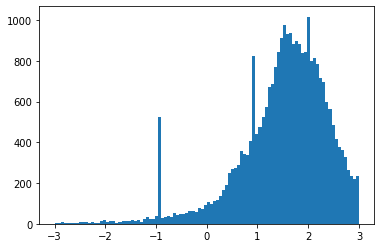

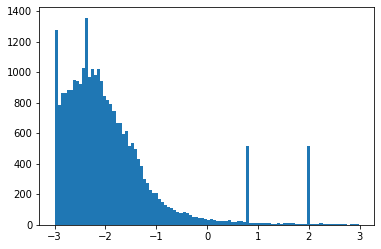

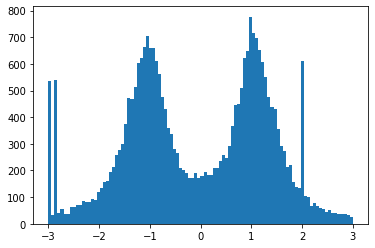

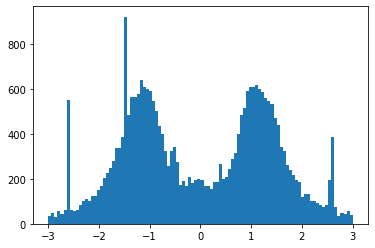

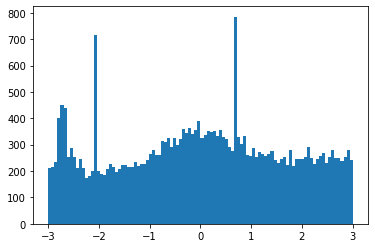

In [ ]:
for i in range(5):
    plt.hist(thetas_all[2000:, i], bins=100)
    plt.show()

In [ ]:
import time
tic = time.time()
for i in range(1):
  key, subkey = random.split(key)
  flow_sample = jnp.std(flow.sample(subkey, condition=jnp.tile(true_params, 100).reshape(-1, 5)), axis=0)
toc = time.time()
flow_sample

DeviceArray([0.78182244, 0.523816  , 0.51070535, 0.47388193, 0.489689  ,
             0.4763476 , 0.69888544, 0.479808  , 0.44396937, 0.43908063],            dtype=float32)

In [ ]:
key, subkey = random.split(key)
flow_sample = flow.sample(subkey, condition=jnp.repeat(true_params, 1000).reshape((-1, 5)))
key, subkey = random.split(key)
true_samples = true_dgp(*true_params, 1000, key=subkey)

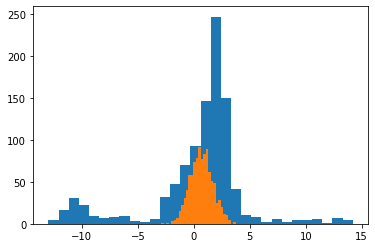

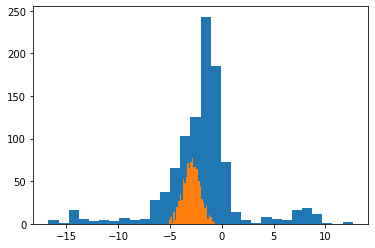

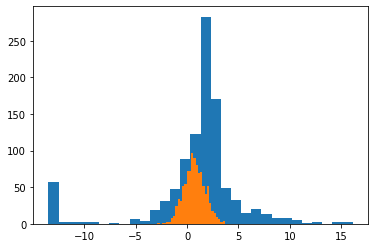

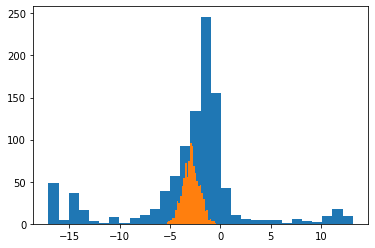

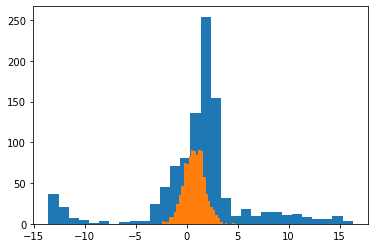

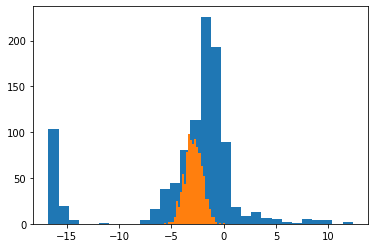

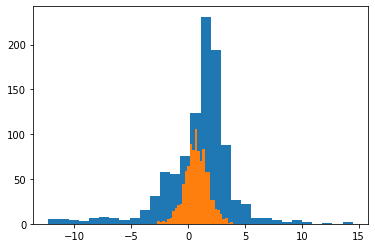

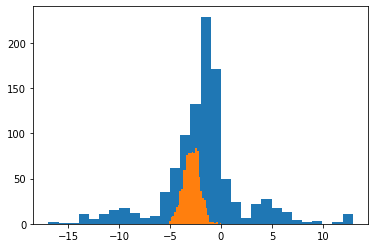

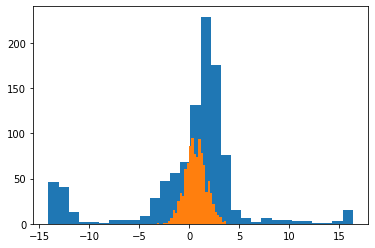

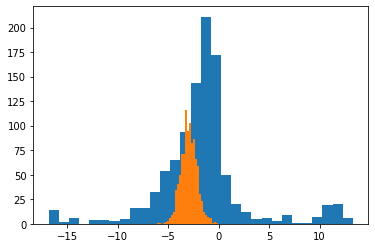

In [ ]:
for i in range(10):
  plt.hist((flow_sample[:, i]*standardisation_params['x_sims_std'][i]) + standardisation_params['x_sims_mean'][i], bins=30)
  plt.hist(true_samples[:, i], bins=30)
  plt.show()

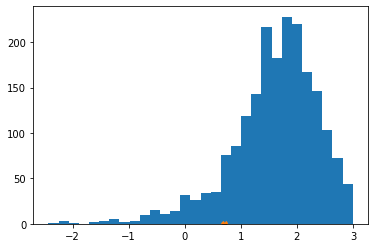

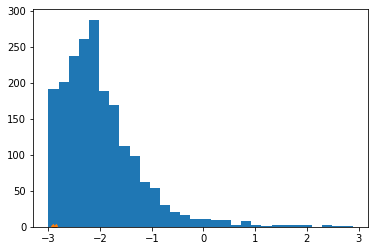

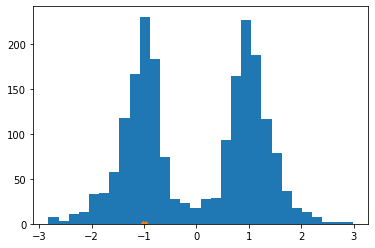

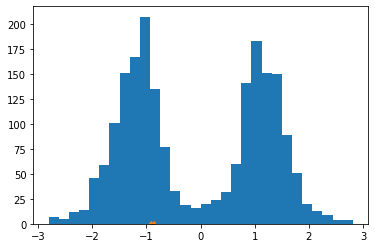

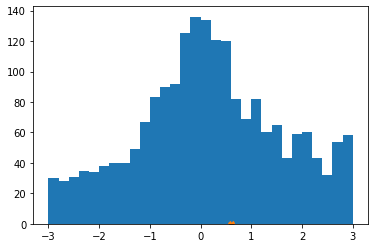

In [ ]:
for i in range(5):
  plt.hist(thetas[:, i], bins=30)
  plt.plot(true_params[i], 0, marker='X')
  plt.show()

In [ ]:
x_obs_standard

DeviceArray([-3.0016819e-01, -1.3071454e-01,  2.8686792e-01,
              1.5430142e-01,  4.7502312e-01, -4.9032032e-01,
              3.8611427e-02, -7.0149457e-01, -5.6262768e+01,
             -2.5296291e+01], dtype=float32)

In [ ]:
# SAMPLE FINAL POSTERIOR
nuts_kernel = NUTS(model, dense_mass=True, target_accept_prob=0.95) #, target_accept_prob=0.95)
mcmc = MCMC(nuts_kernel, num_warmup=2500, num_samples=25000, thinning=1, num_chains=num_chains)  # TODO: MADE NUMBERS UP
key, subkey1, subkey2 = random.split(key, 3)
cauchy_var = 0.2 * jnp.abs(x_obs_standard)
mcmc.run(subkey1, x_obs_standard, prior, density_estimator=flow, standardisation_params=standardisation_params,
         cauchy_var=cauchy_var,
         init_params=init_params,
         key=subkey2)


  0%|          | 0/27500 [00:00<?, ?it/s]

  0%|          | 0/27500 [00:00<?, ?it/s]

  0%|          | 0/27500 [00:00<?, ?it/s]

  0%|          | 0/27500 [00:00<?, ?it/s]

(array([4.0000e+00, 7.0000e+00, 4.0000e+00, 2.0000e+01, 3.2000e+01,
        6.7000e+01, 1.8900e+02, 6.5400e+02, 2.1740e+03, 6.5320e+03,
        1.3069e+04, 1.4063e+04, 2.4441e+04, 3.4792e+04, 2.9320e+03,
        6.5800e+02, 2.0600e+02, 8.2000e+01, 2.9000e+01, 2.0000e+01,
        9.0000e+00, 6.0000e+00, 4.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-2.1118064 , -1.952068  , -1.7923294 , -1.632591  , -1.4728526 ,
        -1.3131142 , -1.1533756 , -0.9936372 , -0.8338988 , -0.6741603 ,
        -0.5144219 , -0.3546834 , -0.19494495, -0.0352065 ,  0.12453195,
         0.2842704 ,  0.44400886,  0.6037473 ,  0.7634858 ,  0.9232242 ,
         1.0829626 ,  1.2427012 ,  1.4024396 ,  1.562178  ,  1.7219164 ,
         1.881655  ,  2.0413933 ,  2.2011318 ,  2.3608704 ,  2.5206087 ,
         2.6803472 ], dtype=float32),
 <a list of 30 Patch objects>)

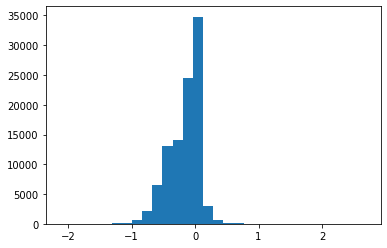

In [ ]:
plt.hist(jnp.squeeze(mcmc.get_samples()['adj_params'][:, 0]), bins=30)

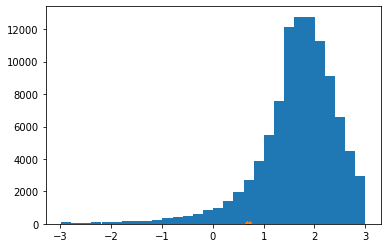

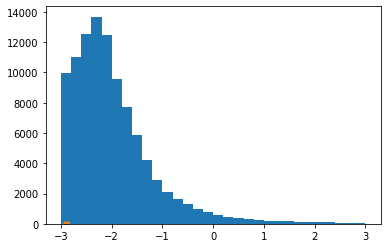

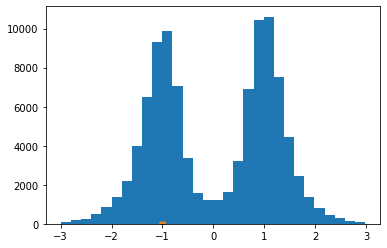

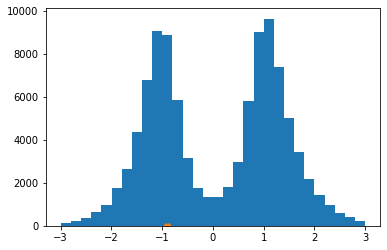

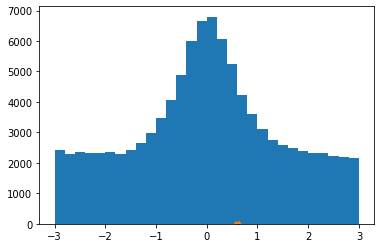

In [ ]:
for i in range(5):
  plt.hist(mcmc.get_samples()['theta'][:, i], bins=30)
  plt.plot(true_params[i], 0, marker='X')
  plt.show()

In [ ]:
key, subkey = random.split(key)
# numpyro.render_model(model, model_args=(x_obs, prior, flow, subkey), render_distributions=True)

In [ ]:
mcmc.print_summary()  


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -0.17      0.24     -0.08     -0.58      0.12  10423.86      1.00
adj_params[1]     -0.00      0.13      0.00     -0.14      0.14   6979.73      1.00
adj_params[2]      0.07      0.21      0.02     -0.19      0.37  10674.73      1.00
adj_params[3]      0.08      0.18      0.02     -0.12      0.40  10051.80      1.00
adj_params[4]      0.17      0.27      0.11     -0.17      0.58  12282.92      1.00
adj_params[5]     -0.15      0.30     -0.08     -0.64      0.21  14795.87      1.00
adj_params[6]     -0.00      0.07     -0.00     -0.05      0.05   4577.43      1.00
adj_params[7]     -0.28      0.34     -0.24     -0.81      0.19  14311.94      1.00
adj_params[8]    -56.35      0.63    -56.36    -57.25    -55.42  17177.72      1.00
adj_params[9]    -25.21      0.71    -25.16    -26.35    -24.21  17815.79      1.00
     theta[0]      1.66      0.79      1.76      0.69      2.95  15747.11  

In [ ]:
import arviz as az
# az.style.use("arviz-doc")

In [ ]:
inference_data = az.from_numpyro(mcmc)

In [ ]:
folder_name = "vis/rsnl_slcp"

In [ ]:
import os
isExist = os.path.exists(folder_name)
if not isExist:
  os.makedirs(folder_name)

/usr/local/lib/python3.8/dist-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (30), generating only 20 plots
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (120) in plot_autocorr, generating only 40 plots
  warnings.warn(


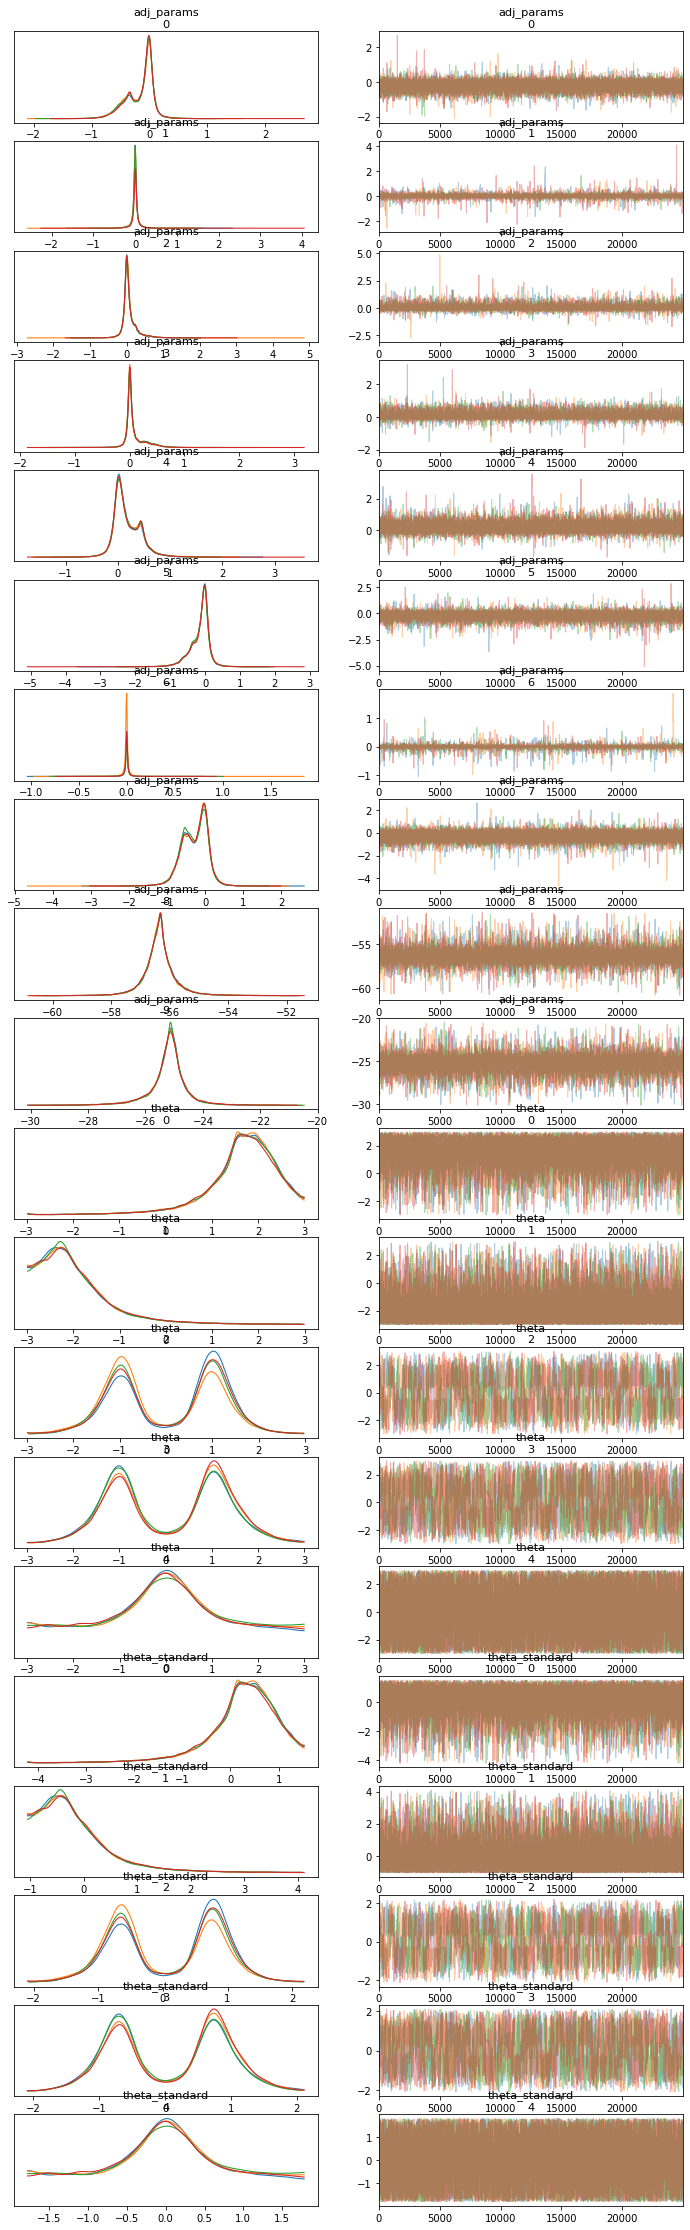

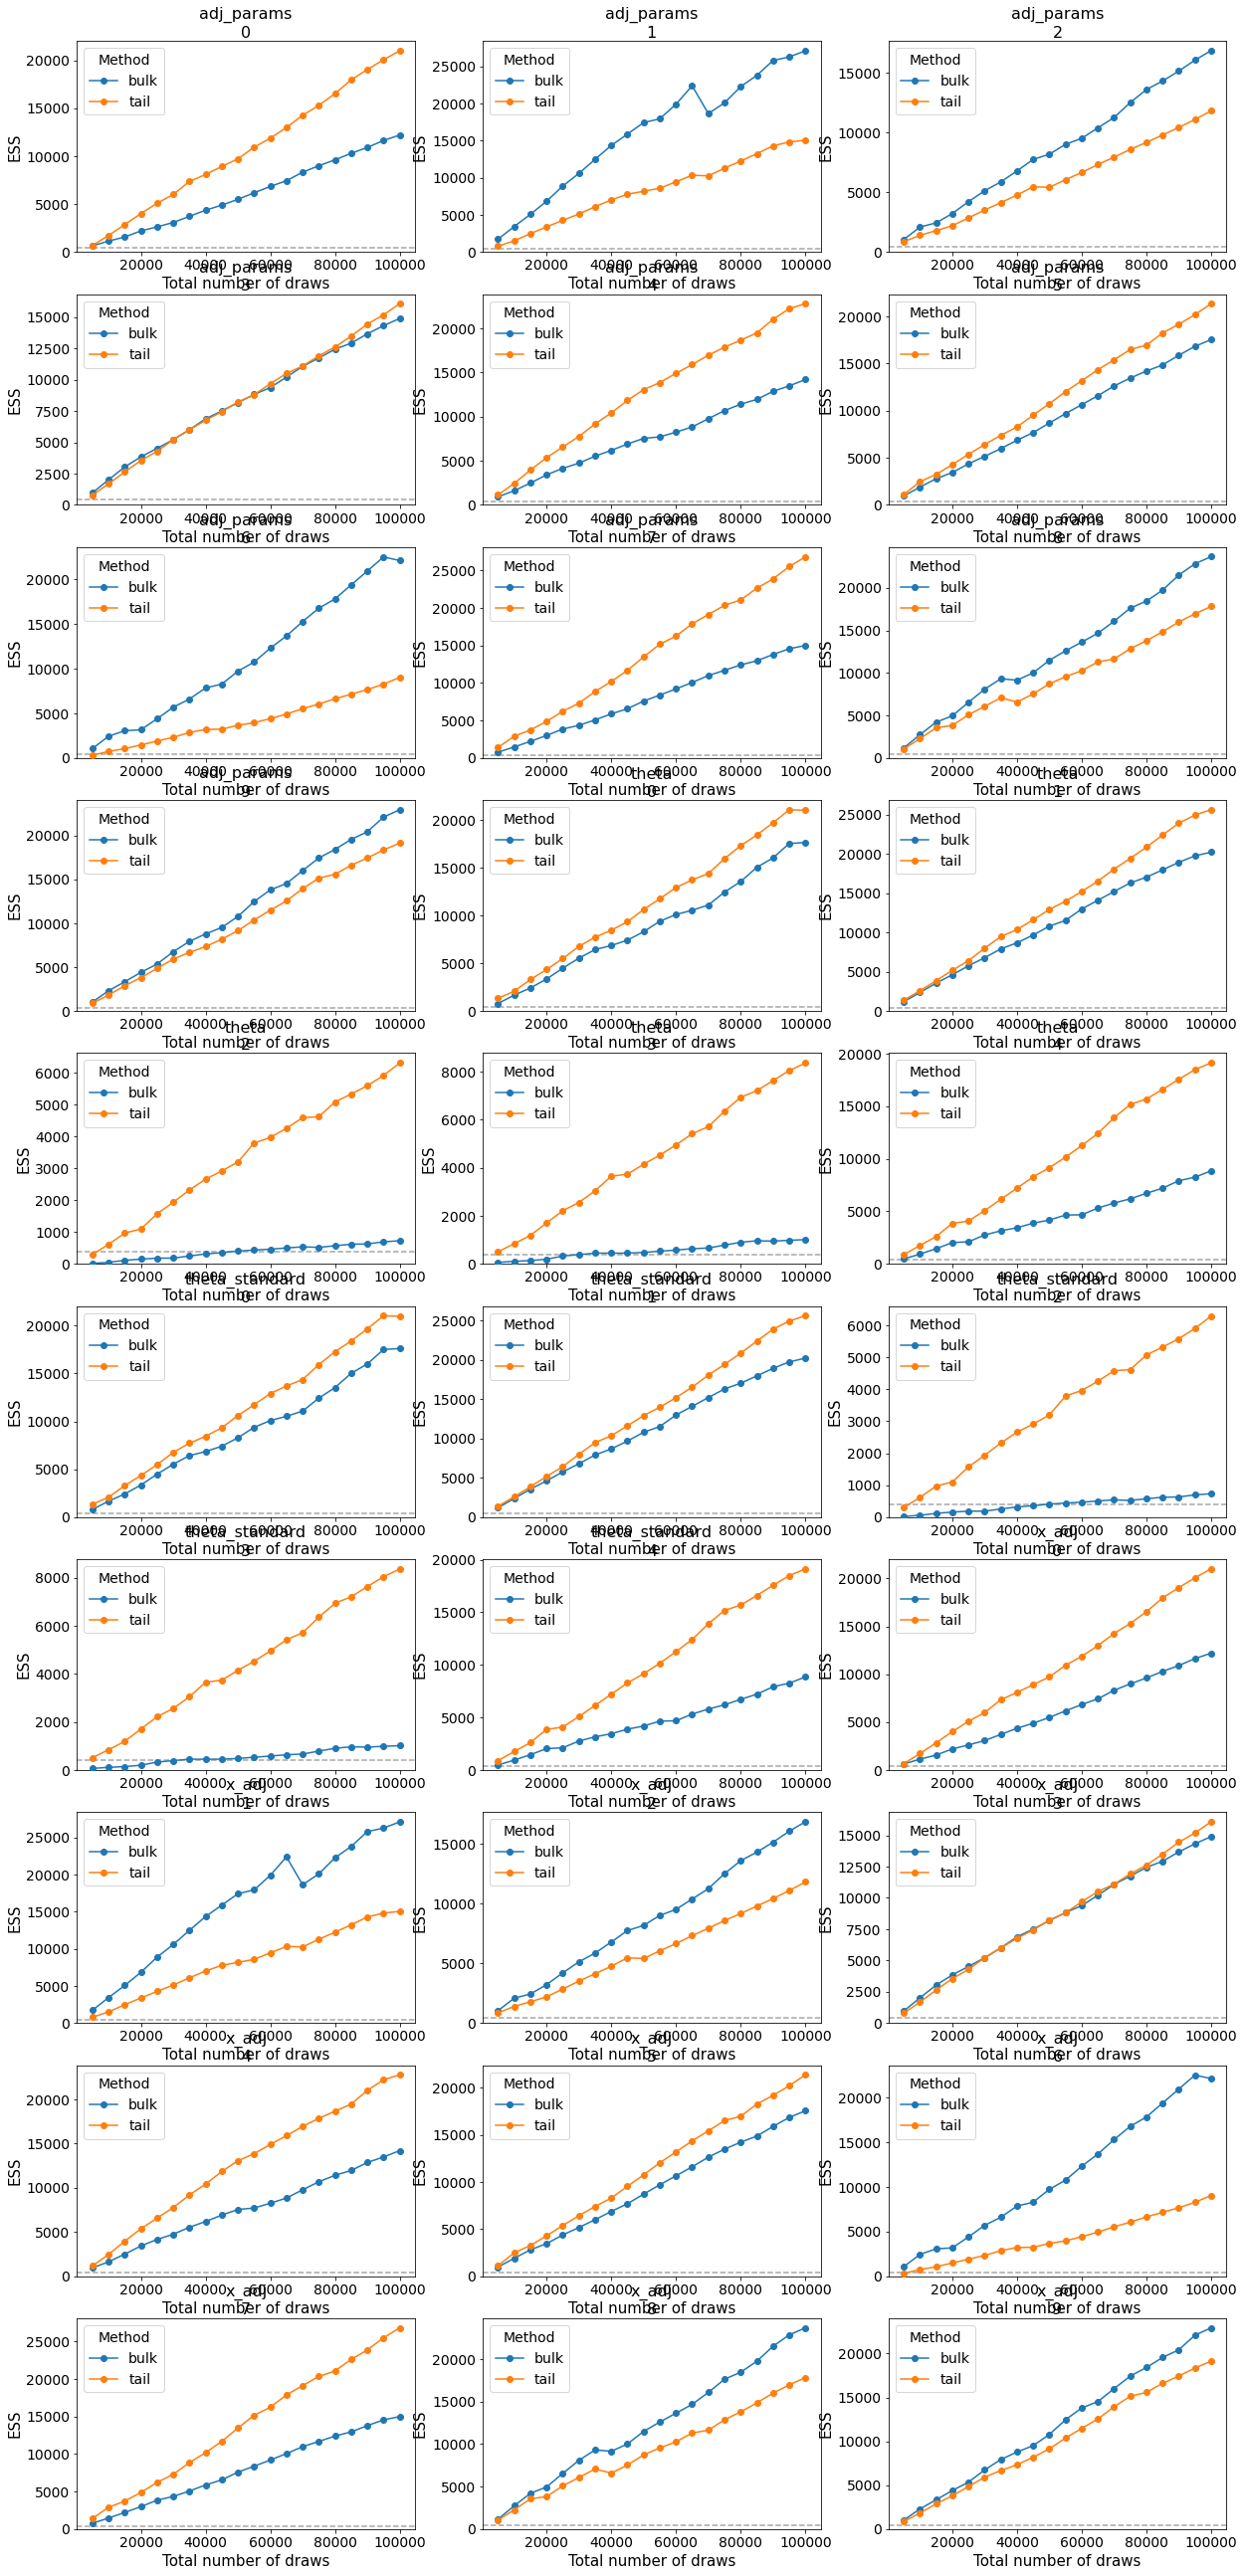

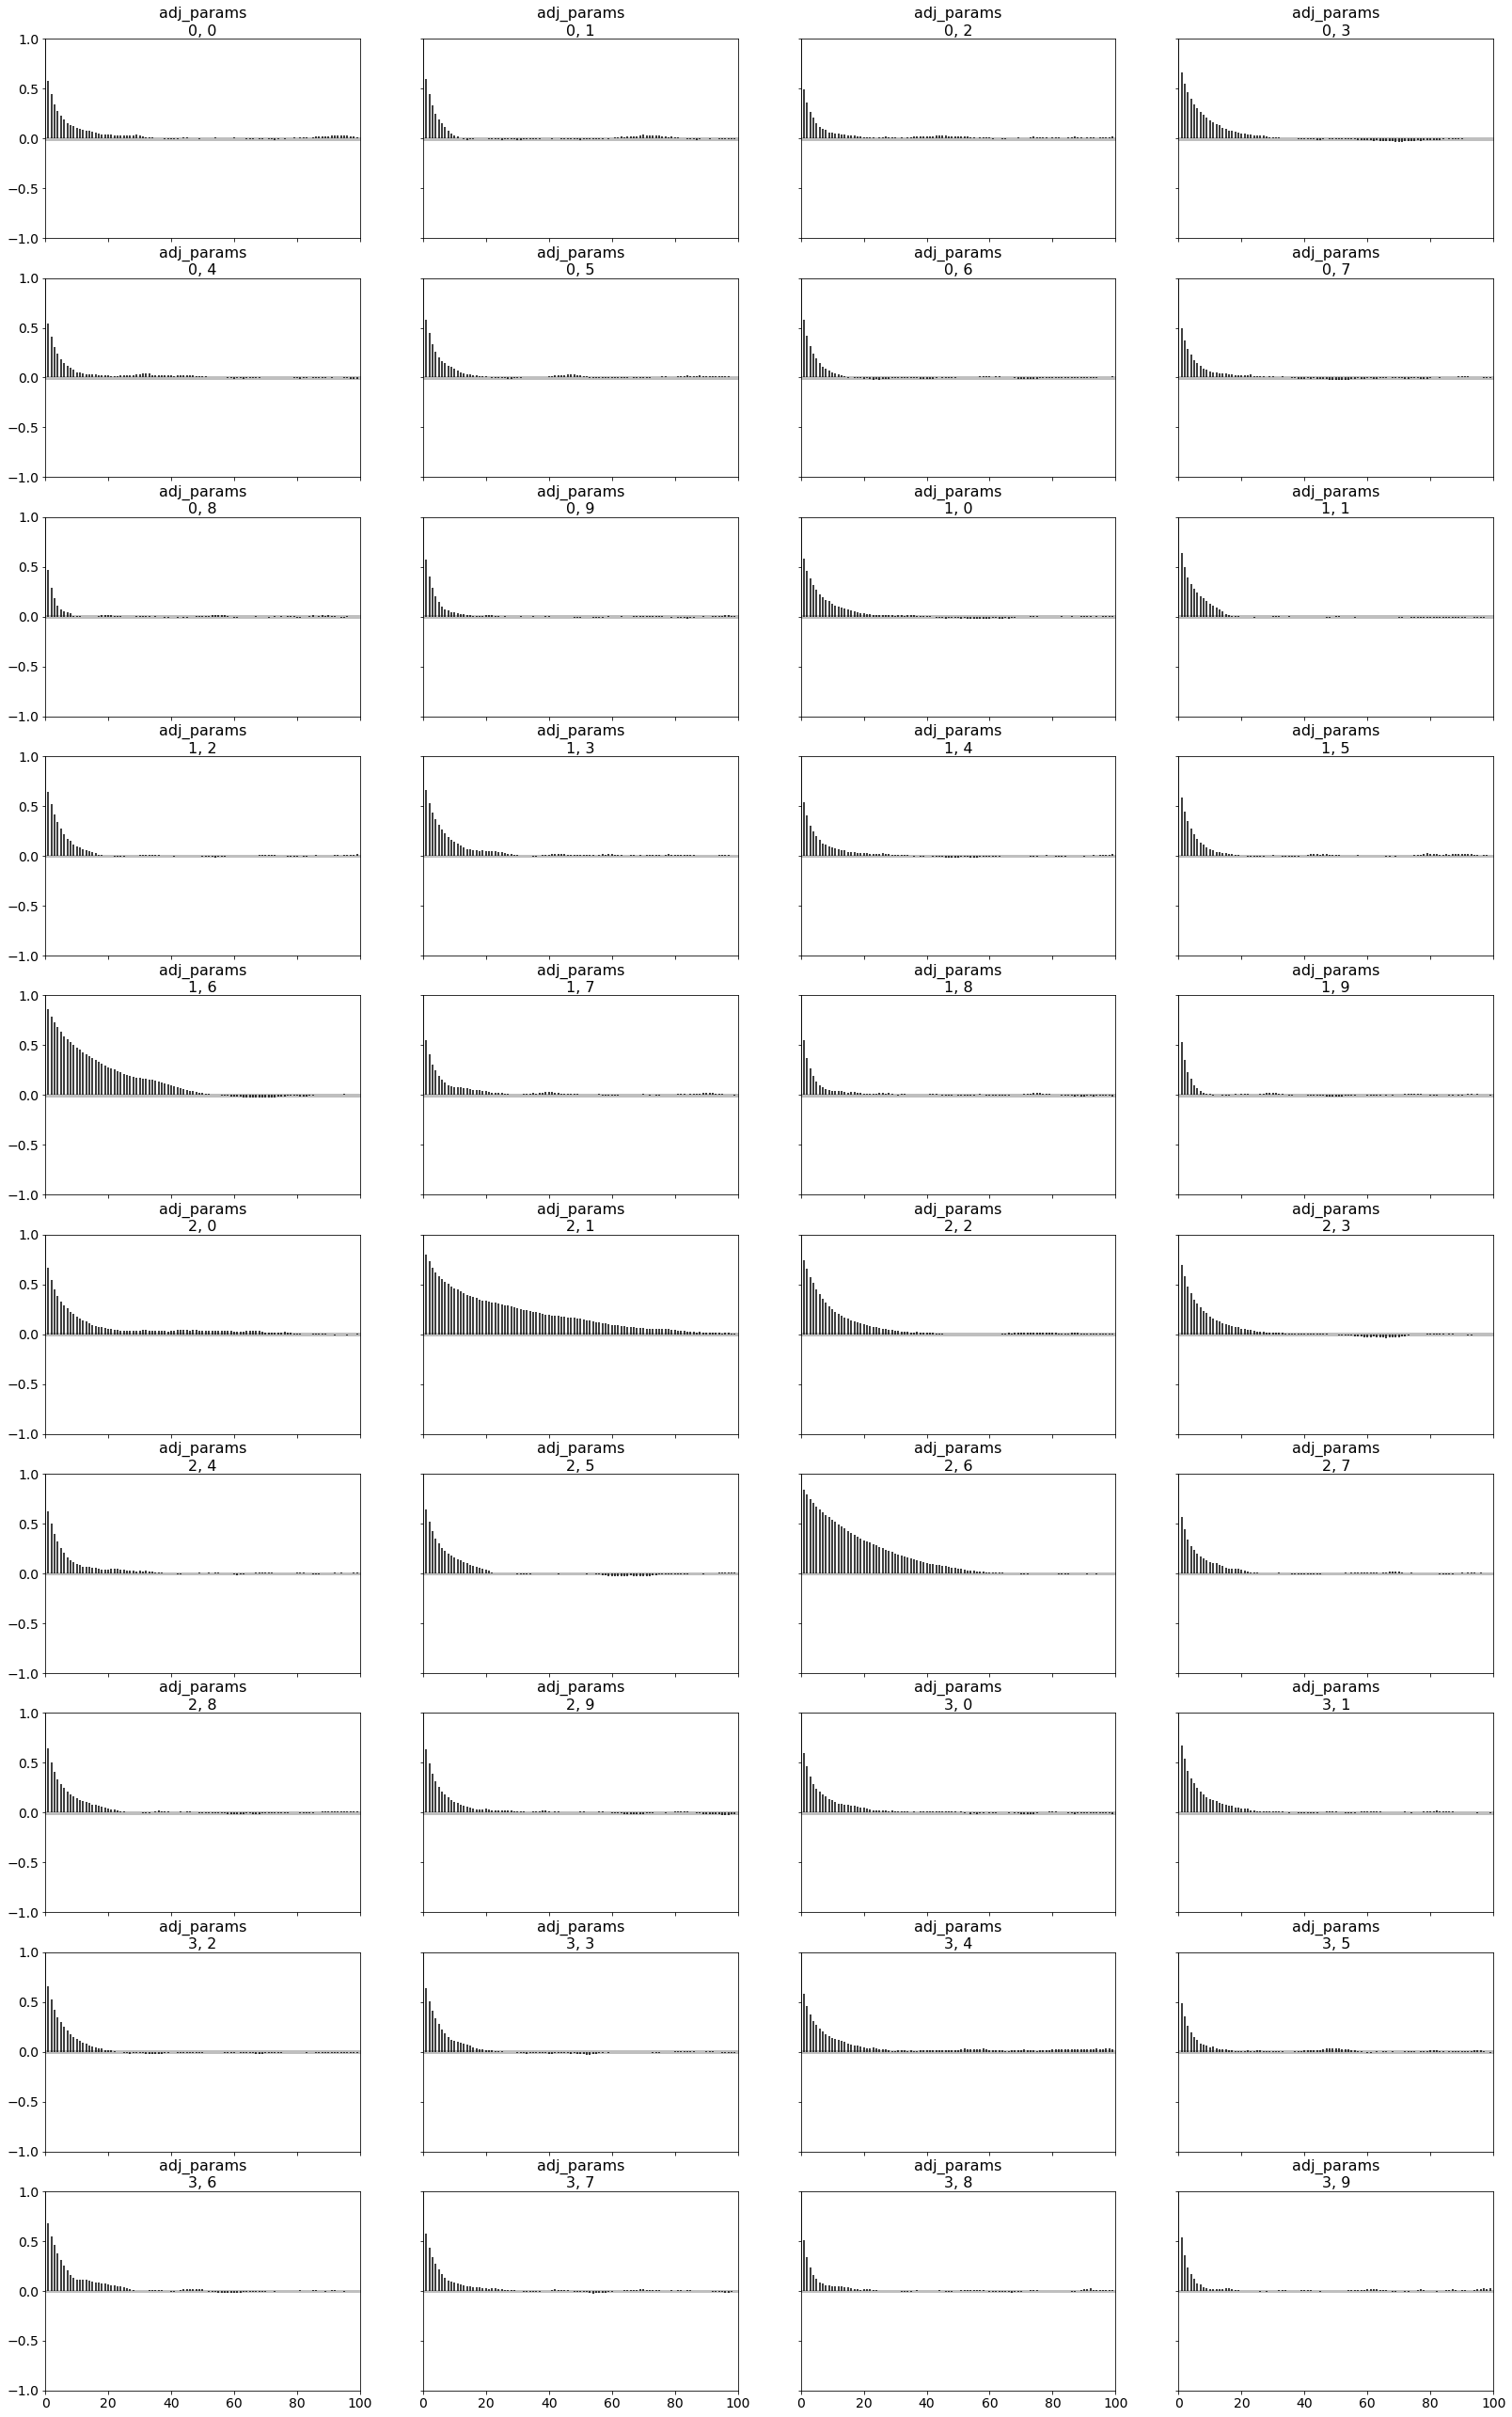

In [ ]:
az.plot_trace(inference_data, compact=False);
plt.savefig(f"{folder_name}_traceplots.png")
az.plot_ess(inference_data, kind="evolution");
plt.savefig(f"{folder_name}_ess_plots.png")
az.plot_autocorr(inference_data);
plt.savefig(f"{folder_name}_autocorr.png")


In [ ]:
theta_plot = {}
for i in range(theta_dims):
    theta_plot['theta' + str(i+1)] = inference_data.posterior.theta[:, :, i].values.flatten()

var_name_map = {}
reference_values = {}
for ii, k in enumerate(theta_plot):
    var_name_map[k] = fr'$\{k[:-1]}_{k[-1]}$'
    reference_values[var_name_map[k]] = true_params[ii]  # why does ref_vals match labels and not data? ah well

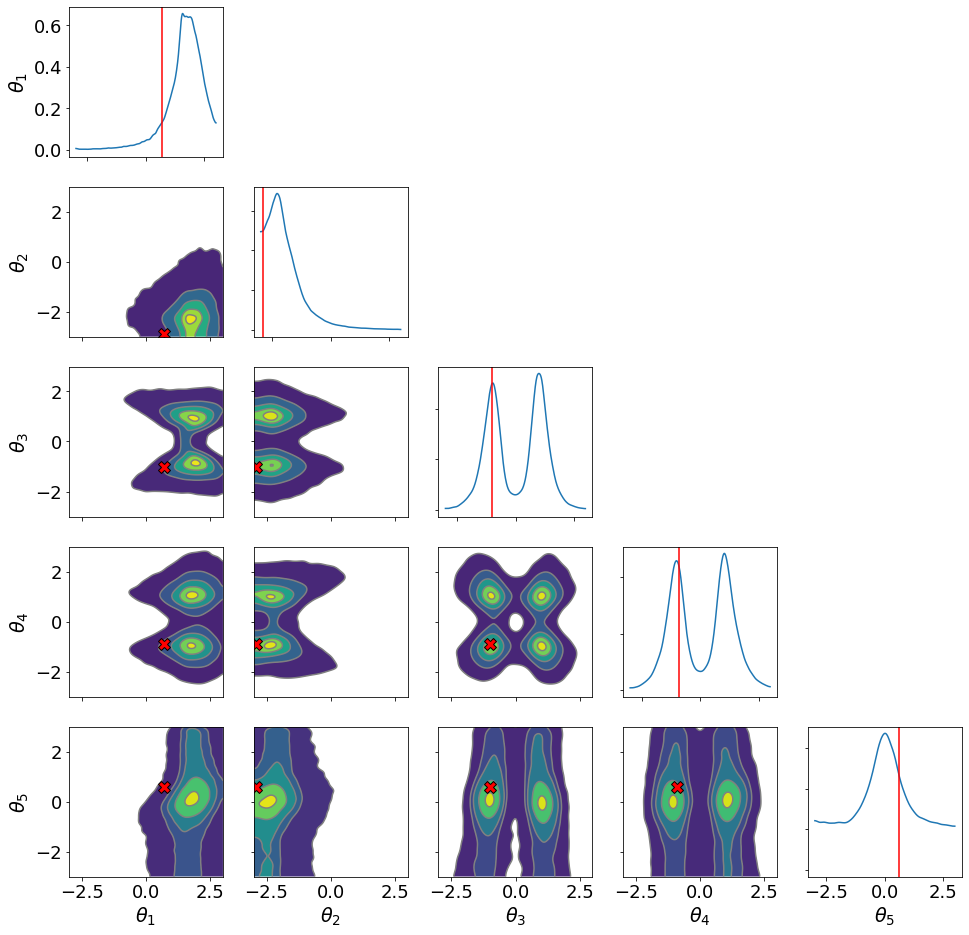

In [ ]:

# fig = plt.figure()
fig, axes = plt.subplots(5, 5, sharey=False, figsize=(16, 16))
# fig, axes = plt.subplots(4, 4)
axes = az.plot_pair(theta_plot,
                    kind='kde',
                    reference_values=reference_values,
                    reference_values_kwargs={'color': 'red', 'marker': 'X', 'markersize': 12},
                    kde_kwargs={'hdi_probs': [0.05, 0.25, 0.5, 0.75, 0.95]},
                    ax=axes,
                    labeller=az.labels.MapLabeller(var_name_map=var_name_map),
                    textsize=18,
                    marginals=True,
                    marginal_kwargs={}
                    # figsize=(64, 64)
                    )

for ii, ax_ii in enumerate(axes):
    for jj, ax_jj in enumerate(ax_ii):
        if ii == jj:  # only marginal for now
            ax_jj.axvline(x=true_params[jj], color='red')
  

plt.savefig("rsnl_slcp_joint.pdf")

In [ ]:
from google.colab import files
# plt.savefig("joint_kde.pdf", bbox_inches='tight')
# files.download("joint_kde.pdf")

In [ ]:
import numpy as np
import pickle as pkl

with open('rsnl_slcp_thetas.pkl', 'wb') as f: pkl.dump(inference_data.posterior.theta, f)

/usr/local/lib/python3.8/dist-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (30), generating only 20 plots
  warnings.warn(


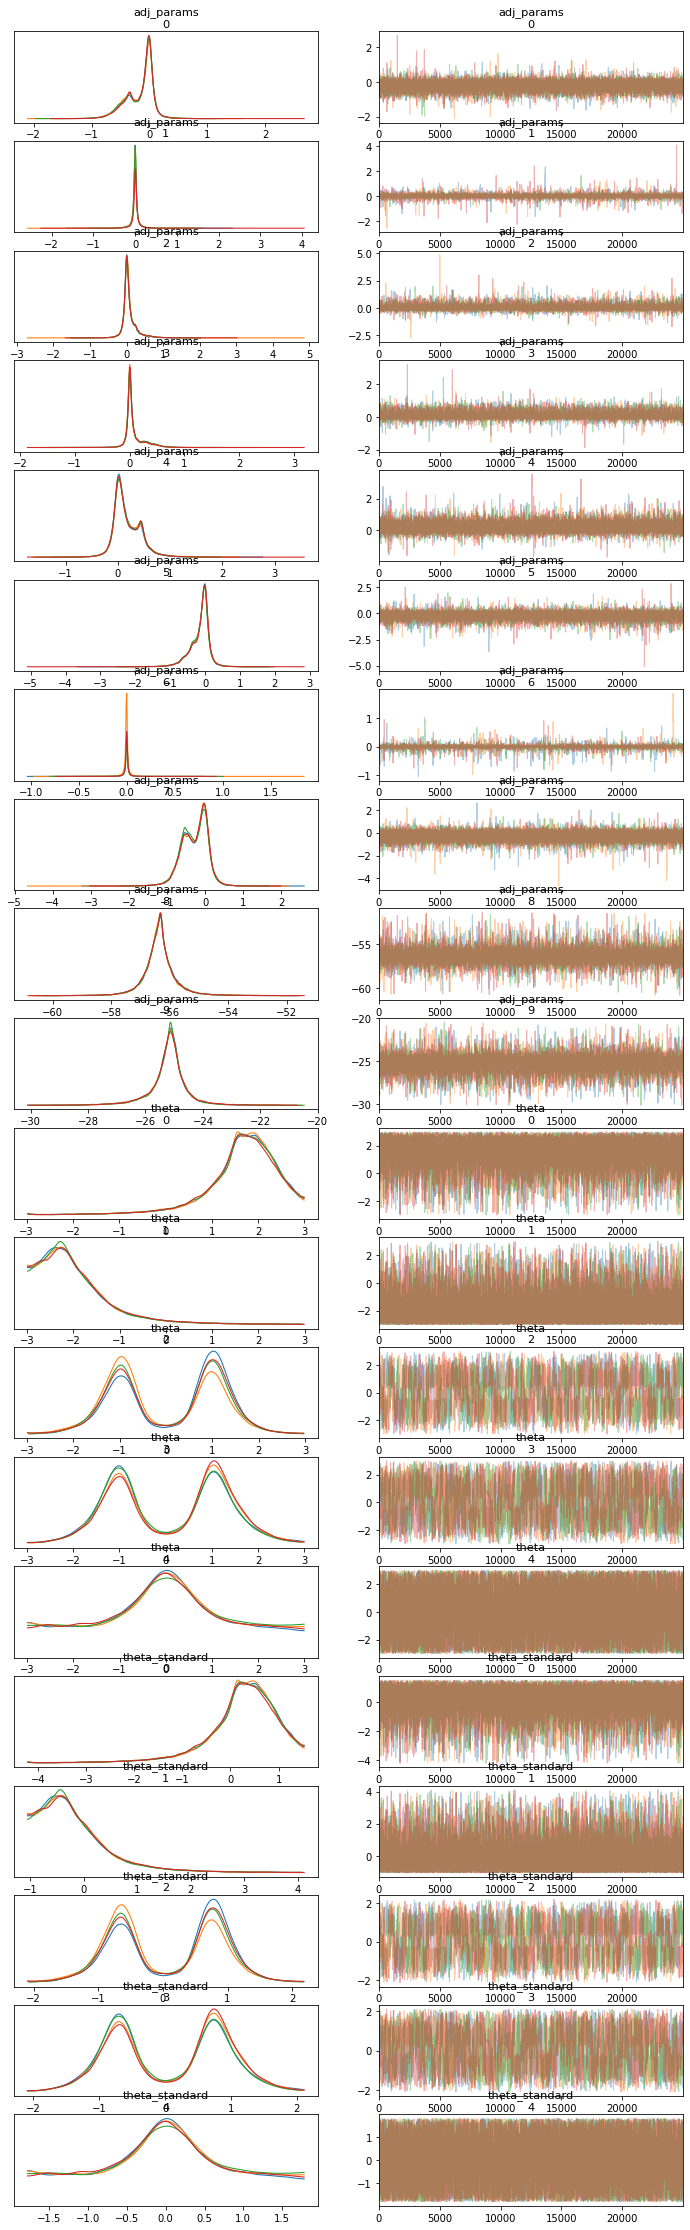

In [ ]:
az.plot_trace(inference_data, compact=False, combined=False);

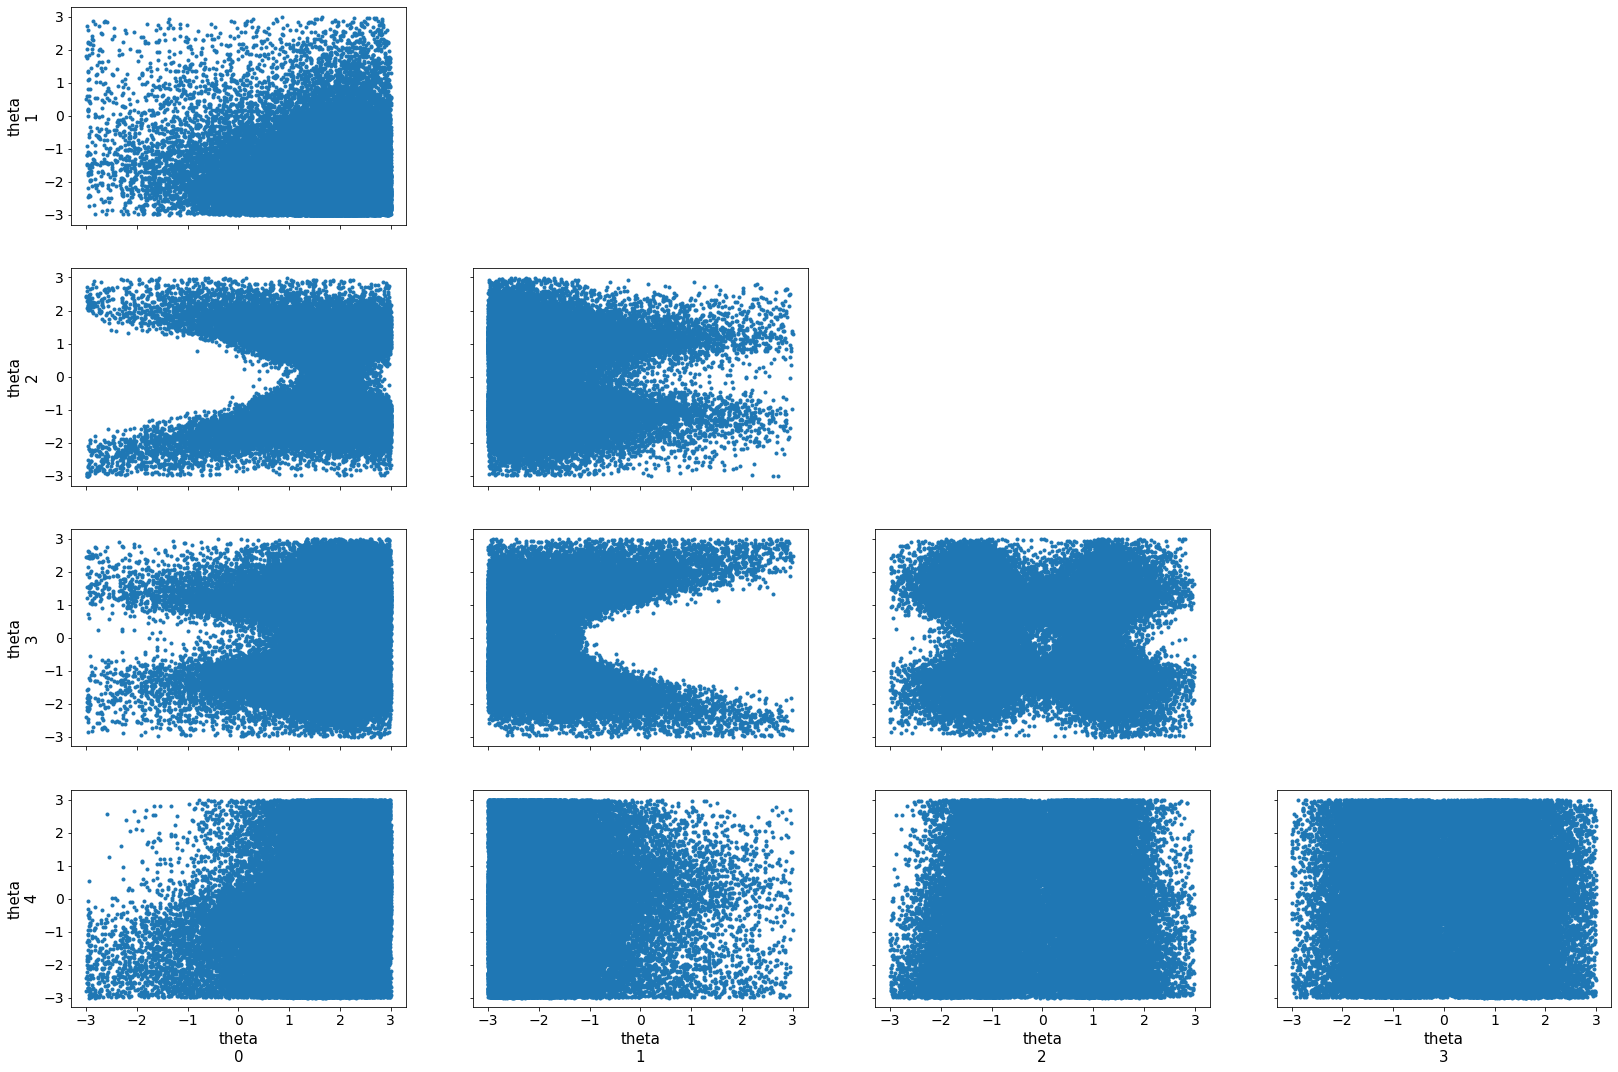

In [ ]:
az.plot_pair(inference_data.posterior.theta);